In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [2]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res
HouseData = LoadHouse()
NofAlgorithms = 9
AlgorithmNames=['Ours', 'Ours-PW', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
AllAcc = {}
AllRtim = {}
AllObj = {}
for baseline in xrange(10,101,10):
    print(' Start baseline: %d' % (baseline))
    AllAcc[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    AllRtim[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    # AllObj[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])

    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,2])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])

        [G, FName1] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, True)
        [G2, FName2] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
        [Gvis, FName1] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, True)
        G.SetVerbose(False)

        # Our results 1
        res1 = FB.BaBSolver(G, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][0][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        #end Our results 1
        
        # Our-PW
        res2 = FB.BaBSolver(G2, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(res2.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][1][ImageI] = res2.Time
        Obj[1][ImageI] = res2.Value
        #end Our-PW
        
        # BCA
        resBag = eng.runBcagm(FName1, nargout=3)
        AllAcc[(baseline-10)/10][3][ImageI] = ComputeAccurancy(resBag[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][3][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA
        
        # BCA-MP
        resBagMP = eng.runBcagmQuad1(FName1, 1,nargout=3)
        AllAcc[(baseline-10)/10][4][ImageI] = ComputeAccurancy(resBagMP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][4][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-MP
        
        # BCA-IPFP
        resBagIPFP = eng.runBcagmQuad1(FName1, 2,nargout=3)
        AllAcc[(baseline-10)/10][5][ImageI] = ComputeAccurancy(resBagIPFP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][5][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-IPFP
        
        # HGM
        resHGM = eng.runHGM(FName1, nargout=3)
        AllAcc[(baseline-10)/10][6][ImageI] = ComputeAccurancy(resHGM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][6][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)
        #end HGM
        
        # RRWHM
        resRRWHM = eng.runRRWHM(FName1, nargout=3)
        #resRRWHM = eng.runBcagm(nargout=3)
        AllAcc[(baseline-10)/10][7][ImageI] = ComputeAccurancy(resRRWHM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][7][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[7][ImageI] = Gvis.ComputeObj(cDecode)
        #end RRWHM
        
        # TensorMatching
        resTM = eng.runTensorMatching(FName1, nargout=3)
        AllAcc[(baseline-10)/10][8][ImageI] = ComputeAccurancy(resTM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][8][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[8][ImageI] = Gvis.ComputeObj(cDecode)
        #end TensorMatching
        
         # Our-BCA Results
        start_time = time.time()
        ResForBca = sio.loadmat(FName1)
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat(FName1, ResForBca)
        resOursBCA = eng.runBcagm(FName1, nargout=3)
        time_dur = time.time() - start_time

        cDecode = FB.intArray(NofNodes)
        #print(resOursBCA[1][0])
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if res1.Value < Gvis.ComputeObj(cDecode): #??? Lee
            AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(resOursBCA[1][0], gTruth, NofNodes)
            Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
            Obj[2][ImageI] = res1.Value
        AllRtim[(baseline-10)/10][2][ImageI] = time_dur + res1.Time
        #end Our-BCA Results
        
        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj
        AllObj[(baseline-10)/10] = Obj
        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     AllAcc[(baseline-10)/10][ai][ImageI],
        #                                                    AllRtim[(baseline-10)/10][ai][ImageI],
        #                                                   AllObj[(baseline-10)/10][ai][ImageI]))
        #print(' Finished Frame: %d ----------------------' % (ImageI) )
        #end inner loop
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(AllAcc[(baseline-10)/10][ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(AllRtim[(baseline-10)/10][ai])
        # MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(AllObj[(baseline-10)/10][ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        MeanAcc[(baseline-10)/10][ai],
                                                        MeanRtime[(baseline-10)/10][ai],
                                                        MeanObj[(baseline-10)/10][ai]))
    print('××××××××××××××××××××')
    #end outer loop

 Start baseline: 10


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.010706 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.008892 Obj 0.807073
Ours-BCA Accuracy 1.000000 Running Time 0.038391 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.020517 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.108045 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.081720 Obj 1.000000
HGM Accuracy 0.709571 Running Time 0.004281 Obj 0.668466
RRWHM Accuracy 1.000000 Running Time 0.051059 Obj 1.000000
TM Accuracy 0.912541 Running Time 0.076426 Obj 0.915234
××××××××××××××××××××
 Start baseline: 20


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.013701 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.013465 Obj 0.816103
Ours-BCA Accuracy 1.000000 Running Time 0.041003 Obj 1.000000
BCA Accuracy 0.998901 Running Time 0.020589 Obj 0.999224
BCA-MP Accuracy 1.000000 Running Time 0.112828 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.084199 Obj 1.000000
HGM Accuracy 0.604762 Running Time 0.004031 Obj 0.567703
RRWHM Accuracy 1.000000 Running Time 0.052107 Obj 1.000000
TM Accuracy 0.841392 Running Time 0.077334 Obj 0.849427
××××××××××××××××××××
 Start baseline: 30


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.040854 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.026850 Obj 0.825678
Ours-BCA Accuracy 1.000000 Running Time 0.069107 Obj 1.000000
BCA Accuracy 0.990535 Running Time 0.020369 Obj 0.996117
BCA-MP Accuracy 0.997942 Running Time 0.117617 Obj 0.999298
BCA-IPFP Accuracy 0.999177 Running Time 0.089721 Obj 0.999810
HGM Accuracy 0.487243 Running Time 0.004238 Obj 0.459507
RRWHM Accuracy 1.000000 Running Time 0.054694 Obj 1.000000
TM Accuracy 0.755144 Running Time 0.081072 Obj 0.771481
××××××××××××××××××××
 Start baseline: 40


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.108333 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.047148 Obj 0.835574
Ours-BCA Accuracy 1.000000 Running Time 0.137320 Obj 1.000000
BCA Accuracy 0.976056 Running Time 0.020524 Obj 0.988871
BCA-MP Accuracy 0.992958 Running Time 0.123908 Obj 0.997181
BCA-IPFP Accuracy 0.987793 Running Time 0.096490 Obj 0.995026
HGM Accuracy 0.392488 Running Time 0.004429 Obj 0.402762
RRWHM Accuracy 1.000000 Running Time 0.058143 Obj 1.000000
TM Accuracy 0.698122 Running Time 0.085260 Obj 0.738163
××××××××××××××××××××
 Start baseline: 50


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.181619 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.057147 Obj 0.846035
Ours-BCA Accuracy 1.000000 Running Time 0.209838 Obj 1.000000
BCA Accuracy 0.922404 Running Time 0.022114 Obj 0.965635
BCA-MP Accuracy 0.991257 Running Time 0.144035 Obj 0.996800
BCA-IPFP Accuracy 0.965027 Running Time 0.101349 Obj 0.984032
HGM Accuracy 0.314754 Running Time 0.004398 Obj 0.360781
RRWHM Accuracy 1.000000 Running Time 0.058693 Obj 1.000000
TM Accuracy 0.621858 Running Time 0.083777 Obj 0.682046
××××××××××××××××××××
 Start baseline: 60


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.268371 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.085285 Obj 0.856132
Ours-BCA Accuracy 1.000000 Running Time 0.293326 Obj 1.000000
BCA Accuracy 0.810458 Running Time 0.019535 Obj 0.905480
BCA-MP Accuracy 0.952941 Running Time 0.145642 Obj 0.982171
BCA-IPFP Accuracy 0.879085 Running Time 0.108281 Obj 0.950880
HGM Accuracy 0.262745 Running Time 0.003587 Obj 0.334958
RRWHM Accuracy 1.000000 Running Time 0.056597 Obj 1.000000
TM Accuracy 0.579085 Running Time 0.071076 Obj 0.671254
××××××××××××××××××××
 Start baseline: 70


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.405607 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.114987 Obj 0.865044
Ours-BCA Accuracy 1.000000 Running Time 0.430996 Obj 1.000000
BCA Accuracy 0.734146 Running Time 0.019827 Obj 0.873533
BCA-MP Accuracy 0.887805 Running Time 0.148508 Obj 0.959118
BCA-IPFP Accuracy 0.816260 Running Time 0.117869 Obj 0.924268
HGM Accuracy 0.256098 Running Time 0.003637 Obj 0.328887
RRWHM Accuracy 1.000000 Running Time 0.058483 Obj 1.000000
TM Accuracy 0.525203 Running Time 0.067570 Obj 0.645312
××××××××××××××××××××
 Start baseline: 80


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.498838 Obj 1.000000
Ours-PW Accuracy 1.000000 Running Time 0.157034 Obj 0.871508
Ours-BCA Accuracy 1.000000 Running Time 0.525380 Obj 1.000000
BCA Accuracy 0.611828 Running Time 0.019520 Obj 0.815680
BCA-MP Accuracy 0.791398 Running Time 0.205230 Obj 0.913880
BCA-IPFP Accuracy 0.732258 Running Time 0.128362 Obj 0.883730
HGM Accuracy 0.221505 Running Time 0.003615 Obj 0.323782
RRWHM Accuracy 1.000000 Running Time 0.060765 Obj 1.000000
TM Accuracy 0.349462 Running Time 0.067442 Obj 0.554112
××××××××××××××××××××
 Start baseline: 90


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 1.000000 Running Time 0.542794 Obj 1.000000
Ours-PW Accuracy 0.996825 Running Time 0.212287 Obj 0.876840
Ours-BCA Accuracy 1.000000 Running Time 0.568080 Obj 1.000000
BCA Accuracy 0.525397 Running Time 0.019975 Obj 0.780436
BCA-MP Accuracy 0.612698 Running Time 0.235078 Obj 0.839226
BCA-IPFP Accuracy 0.577778 Running Time 0.137116 Obj 0.816680
HGM Accuracy 0.184127 Running Time 0.003605 Obj 0.325070
RRWHM Accuracy 0.996825 Running Time 0.063892 Obj 0.999851
TM Accuracy 0.296825 Running Time 0.066623 Obj 0.535220
××××××××××××××××××××
 Start baseline: 100


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

Ours Accuracy 0.993939 Running Time 0.500597 Obj 0.996975
Ours-PW Accuracy 0.984848 Running Time 0.245585 Obj 0.882167
Ours-BCA Accuracy 0.993939 Running Time 0.526279 Obj 0.996975
BCA Accuracy 0.445455 Running Time 0.020366 Obj 0.765658
BCA-MP Accuracy 0.421212 Running Time 0.258035 Obj 0.774490
BCA-IPFP Accuracy 0.460606 Running Time 0.171908 Obj 0.792841
HGM Accuracy 0.154545 Running Time 0.003623 Obj 0.338011
RRWHM Accuracy 0.993939 Running Time 0.069189 Obj 0.999786
TM Accuracy 0.215152 Running Time 0.067808 Obj 0.505921
××××××××××××××××××××


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.99393939])

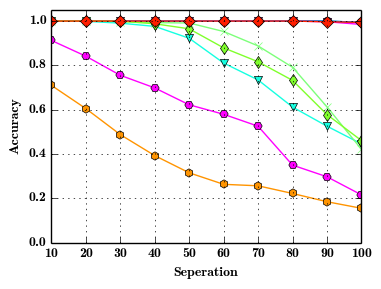

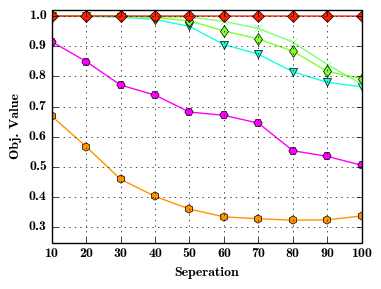

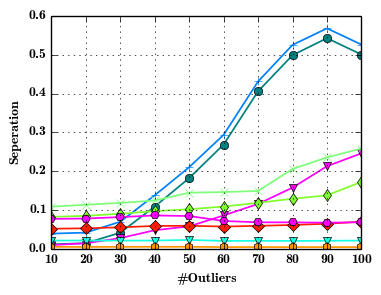

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline

Colors = [[ 0.        ,  0.5       , 0.5        ,  1.        ],
          [ 1.        ,  0.00196078,  1.        ,  1.        ],
          [ 0.        ,  0.50392157,  1.        ,  1.        ],
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],
          [ 1.        ,  0.58169935,  0.        ,  1.        ],
          [ 1.        ,  0.11692084,  0.        ,  1.        ],
          [ 1.        ,  0.        ,  1.        ,  1.        ]]
Seq = [0, 1, 2, 3, 4, 5, 6, 7, 8]
AlgorithmNames=['Ours', 'Ours-PW', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
Markers = ['o', 'v', '+', 'v', 'x', 'd', 'h', 'D', 'H']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('results/Edges_Triplets/House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('results/Edges_Triplets/PlotData.mat', StoreForPlot)

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'Ours')|(AlgorithmNames[Seq[ai]] == 'Ours-BCA')|(AlgorithmNames[Seq[ai]] == 'Ours-PW'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('results/Edges_Triplets/House_Obj.pdf')    # <-- loses transparency


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('results/Edges_Triplets/Car_Time.pdf')    # <-- loses transparency

MeanAcc[:,0]

In [16]:
PT1 = np.copy(HouseData[ImageI])
PT2 = np.copy(HouseData[ImageI+baseline])
NofNodes = 30
gTruth = np.random.permutation(NofNodes)
PT1 = PT1[gTruth, :]
PF1 = np.zeros([NofNodes,1])
PF2 = np.zeros([NofNodes,2])
MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
G = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, True)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)

BaBIter=1, GUB = 100000000000000000000.000000, GLB = -100000000000000000000.000000, Gap = 2.00, Time=0.0027
